In [1]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

In [2]:
def calc_cov_ellipse(mu, Sigma, unit_vecs):

    # perform SVD on covariance matrix in order to transform into desired distribution: N(mu, Sigma)
    U, s, Vh = np.linalg.svd(Sigma)
    s_sqrt = np.sqrt(s)
    S_sqrt = linalg.diagsvd(s_sqrt, Sigma.shape[0], Sigma.shape[1])
    Sigma_sqrt = Vh.T @ S_sqrt @ Vh

    # transform unit vectors so that they are now distributed as N(0, Z_sigma)
    cov_ellipse = Sigma_sqrt @ unit_vecs

    # transform ellipse to be distributed as N(Z_mu, Z_Sigma)
    cov_ellipse = mu[:, None] + cov_ellipse # must convert mu to col vector in order to broadcast correctly

    return cov_ellipse


In [3]:
def calc_posterior_cov(Sigma_vis, Sigma_prop):
    
    # find inverses of Sigma_vis and Sigma_pro
    Sigma_vis_inv = np.linalg.inv(Sigma_vis)
    Sigma_prop_inv = np.linalg.inv(Sigma_prop)
    
    # equation for the posterior distribution's covariance 
    Sigma_posterior = np.linalg.inv(Sigma_vis_inv + Sigma_prop_inv)
    
    return(Sigma_posterior)

In [4]:
def calc_posterior_mu(mu_vis, mu_prop, Sigma_vis, Sigma_prop, Sigma_posterior):
    
    # find mu of the posterior
    Sigma_vis_inv = np.linalg.inv(Sigma_vis)
    Sigma_prop_inv = np.linalg.inv(Sigma_prop)
    mu_posterior = Sigma_posterior @ (Sigma_prop_inv @ mu_prop + Sigma_vis_inv @ mu_vis)
    
    return mu_posterior

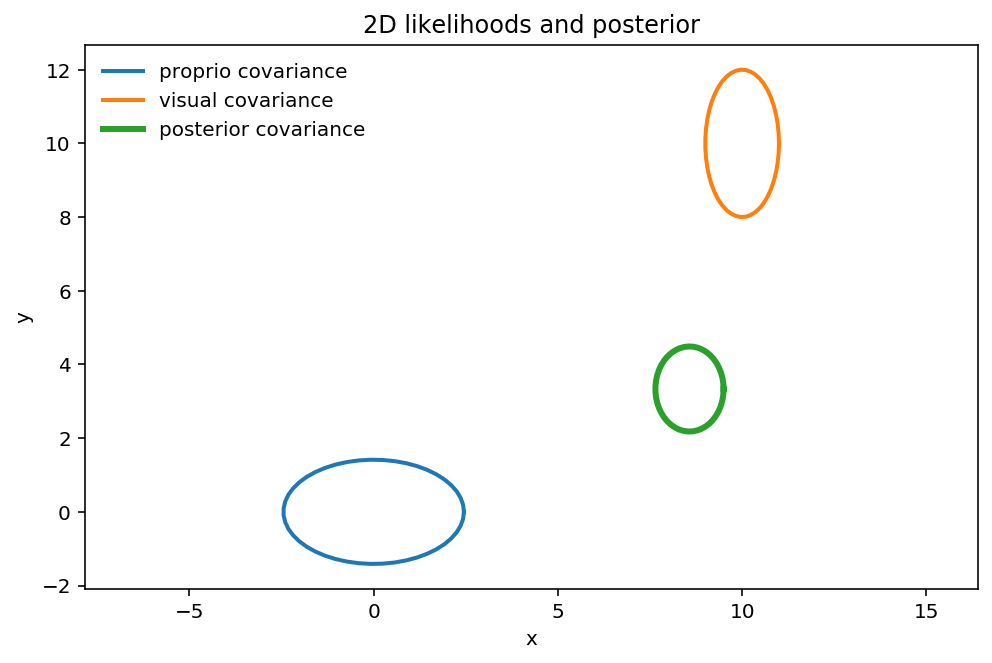

In [5]:
# creating 48 unit vectors to project our data onto
num_steps = 48
theta = np.linspace(0, 2*np.pi, num_steps)
unit_vecs = np.vstack((np.cos(theta), np.sin(theta)))

# Initialize unimodal covariances and calculate posterior covariance
Sigma_prop = np.array([[6, 0], [0, 2]])
Sigma_vis = np.array([[1, 0], [0, 4]])
Sigma_posterior = calc_posterior_cov(Sigma_vis, Sigma_prop)

# calculate mus
mu_prop = np.array([0, 0])
mu_vis = np.array([10, 10])
mu_posterior = calc_posterior_mu(mu_vis, mu_prop, Sigma_vis, Sigma_prop, Sigma_posterior)

# caculate ellipses
prop_ellipse = calc_cov_ellipse(mu_prop, Sigma_prop, unit_vecs)
vis_ellipse = calc_cov_ellipse(mu_vis, Sigma_vis, unit_vecs)
post_ellipse = calc_cov_ellipse(mu_posterior, Sigma_posterior, unit_vecs)

# plot one instance of posterior
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(prop_ellipse[0,:], prop_ellipse[1,:], linewidth=2, label='proprio covariance')
ax.plot(vis_ellipse[0,:], vis_ellipse[1,:], linewidth=2, label='visual covariance')
ax.plot(post_ellipse[0,:], post_ellipse[1,:], linewidth=3, label='posterior covariance')
ax.set(xlabel='x', ylabel='y')
plt.title('2D likelihoods and posterior')
ax.axis('equal')
ax.legend(frameon=False);

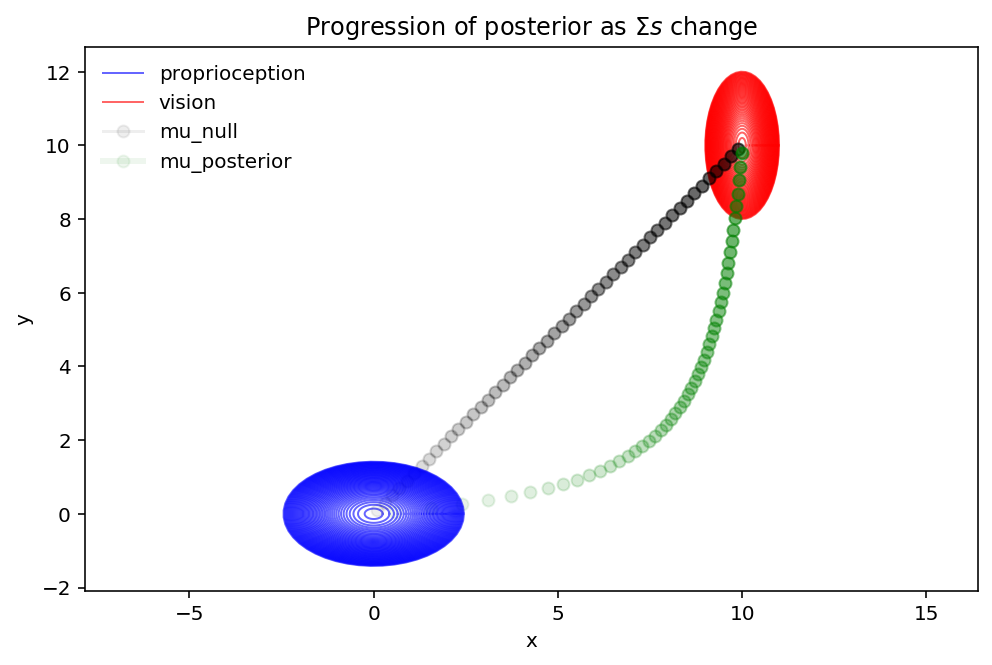

In [6]:
# create circular unit vectors we will transform into covariance ellipses
num_steps = 48
theta = np.linspace(0, 2*np.pi, num_steps)
unit_vecs = np.vstack((np.cos(theta), np.sin(theta)))

# scaling factor for Sigmas
x = np.linspace(0.01, 1, 50)

# plot figure
fig, ax = plt.subplots(figsize=(8, 5))

for i in x:
    # scale unimodal sigmas
    Sigma_prop = i * np.array([[6, 0], [0, 2]])
    Sigma_vis = (1.01 - i) * np.array([[1, 0], [0, 4]])
    Sigma_prop_null = i * np.eye(2) # for null hypothesis that brain does not account for difference in precisions
    Sigma_vis_null = (1.01 -i) * np.eye(2) # for null hypothesis that brain does not account for difference in precisions
    Sigma_posterior = calc_posterior_cov(Sigma_vis, Sigma_prop)
    Sigma_post_null = calc_posterior_cov(Sigma_vis_null, Sigma_prop_null)
    
    # fixed unimodal mus
    mu_prop = np.array([0, 0])
    mu_vis = np.array([10, 10])
    
    # calculate mu_posterior based on unimodal params
    mu_posterior = calc_posterior_mu(mu_vis, mu_prop, Sigma_vis, Sigma_prop, Sigma_posterior)
    mu_null = calc_posterior_mu(mu_vis, mu_prop, Sigma_vis_null, Sigma_prop_null, Sigma_post_null)
    
    # calculate ellipses
    prop_ellipse = calc_cov_ellipse(mu_prop, Sigma_prop, unit_vecs)
    vis_ellipse = calc_cov_ellipse(mu_vis, Sigma_vis, unit_vecs)
    post_ellipse = calc_cov_ellipse(mu_posterior, Sigma_posterior, unit_vecs)
    
    #plot figure
    ax.plot(prop_ellipse[0, :], prop_ellipse[1, :], c='b', alpha=0.6, linewidth=1, label='proprio covariance')
    ax.plot(vis_ellipse[0, :], vis_ellipse[1, :], c='r',  alpha=0.6, linewidth=1, label='visual covariance')
    ax.plot(mu_null[0], mu_null[1], c='k', marker='o', alpha=(i + .1)*0.6, label='fake mu')
    ax.plot(mu_posterior[0], mu_posterior[1], marker='o', c='g', alpha=(i + .1)*0.6, linewidth=3, label='posterior covariance')
    ax.set(xlabel='x', ylabel='y')
    ax.axis('equal')

ax.legend(['proprioception', 'vision', 'mu_null', 'mu_posterior'], frameon=False);
plt.title('Progression of posterior as $\Sigma s$ change');

The point of the figure above is to improve and simplify figure 2 from the paper, so we can understand the predictions better. Here, we're looking at one set of proprioceptive and visual ellipses and respective positions of the cue combination prediction (green) that takes into account the precision along each direction of each unimodal ellipse (direction-dependent model, which in reality is a 2d cue combination model). The null hypothesis (black) assumes that these precisions are not taken into account by the brain. 

The simulation progresses from a tiny ellipse for proprioception and a larger ellipse for vision to a large ellipse for proprioception and a tiny ellipse for vision; hence, the mean of the posterior (green dots) goes from being very close to the proprioception ellipse to the center of the vision ellipse. 

In [11]:
import ipywidgets as widgets


def interact(p1 = 6, p2 = 0, p3 = 0, p4 = 2, v1 = 1, v2 = 0, v3 = 0, v4 = 4):
    # creating 48 unit vectors to project our data onto
    num_steps = 48
    theta = np.linspace(0, 2*np.pi, num_steps)
    unit_vecs = np.vstack((np.cos(theta), np.sin(theta)))

    # Initialize unimodal covariances and calculate posterior covariance
    Sigma_prop = np.array([[p1, p2], [p3, p4]])
    Sigma_vis = np.array([[v1, v2], [v3, v4]])
    Sigma_posterior = calc_posterior_cov(Sigma_vis, Sigma_prop)

    # calculate mus
    mu_prop = np.array([0, 0])
    mu_vis = np.array([10, 10])
    mu_posterior = calc_posterior_mu(mu_vis, mu_prop, Sigma_vis, Sigma_prop, Sigma_posterior)

    # caculate ellipses
    prop_ellipse = calc_cov_ellipse(mu_prop, Sigma_prop, unit_vecs)
    vis_ellipse = calc_cov_ellipse(mu_vis, Sigma_vis, unit_vecs)
    post_ellipse = calc_cov_ellipse(mu_posterior, Sigma_posterior, unit_vecs)

    # plot one instance of posterior
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(prop_ellipse[0,:], prop_ellipse[1,:], linewidth=2, label='proprio covariance')
    ax.plot(vis_ellipse[0,:], vis_ellipse[1,:], linewidth=2, label='visual covariance')
    ax.plot(post_ellipse[0,:], post_ellipse[1,:], linewidth=3, label='posterior covariance')
    ax.set(xlabel='x', ylabel='y')
    plt.title('2D likelihoods and posterior')
    ax.axis('equal')
    ax.legend(frameon=False);
    
_ = widgets.interact(interact, p1 = (0,10,0.5), p2 = (-10,10,0.5), p3 = (-10,10,0.5), p4 = (0,10,0.5),\
                     v1 = (0,10,0.5), v2 = (-10,10,0.5), v3 = (-10,10,0.5), v4 = (0,10,0.5))

interactive(children=(FloatSlider(value=6.0, description='p1', max=10.0, step=0.5), FloatSlider(value=0.0, des…

**Important derivations for Bayesian models**

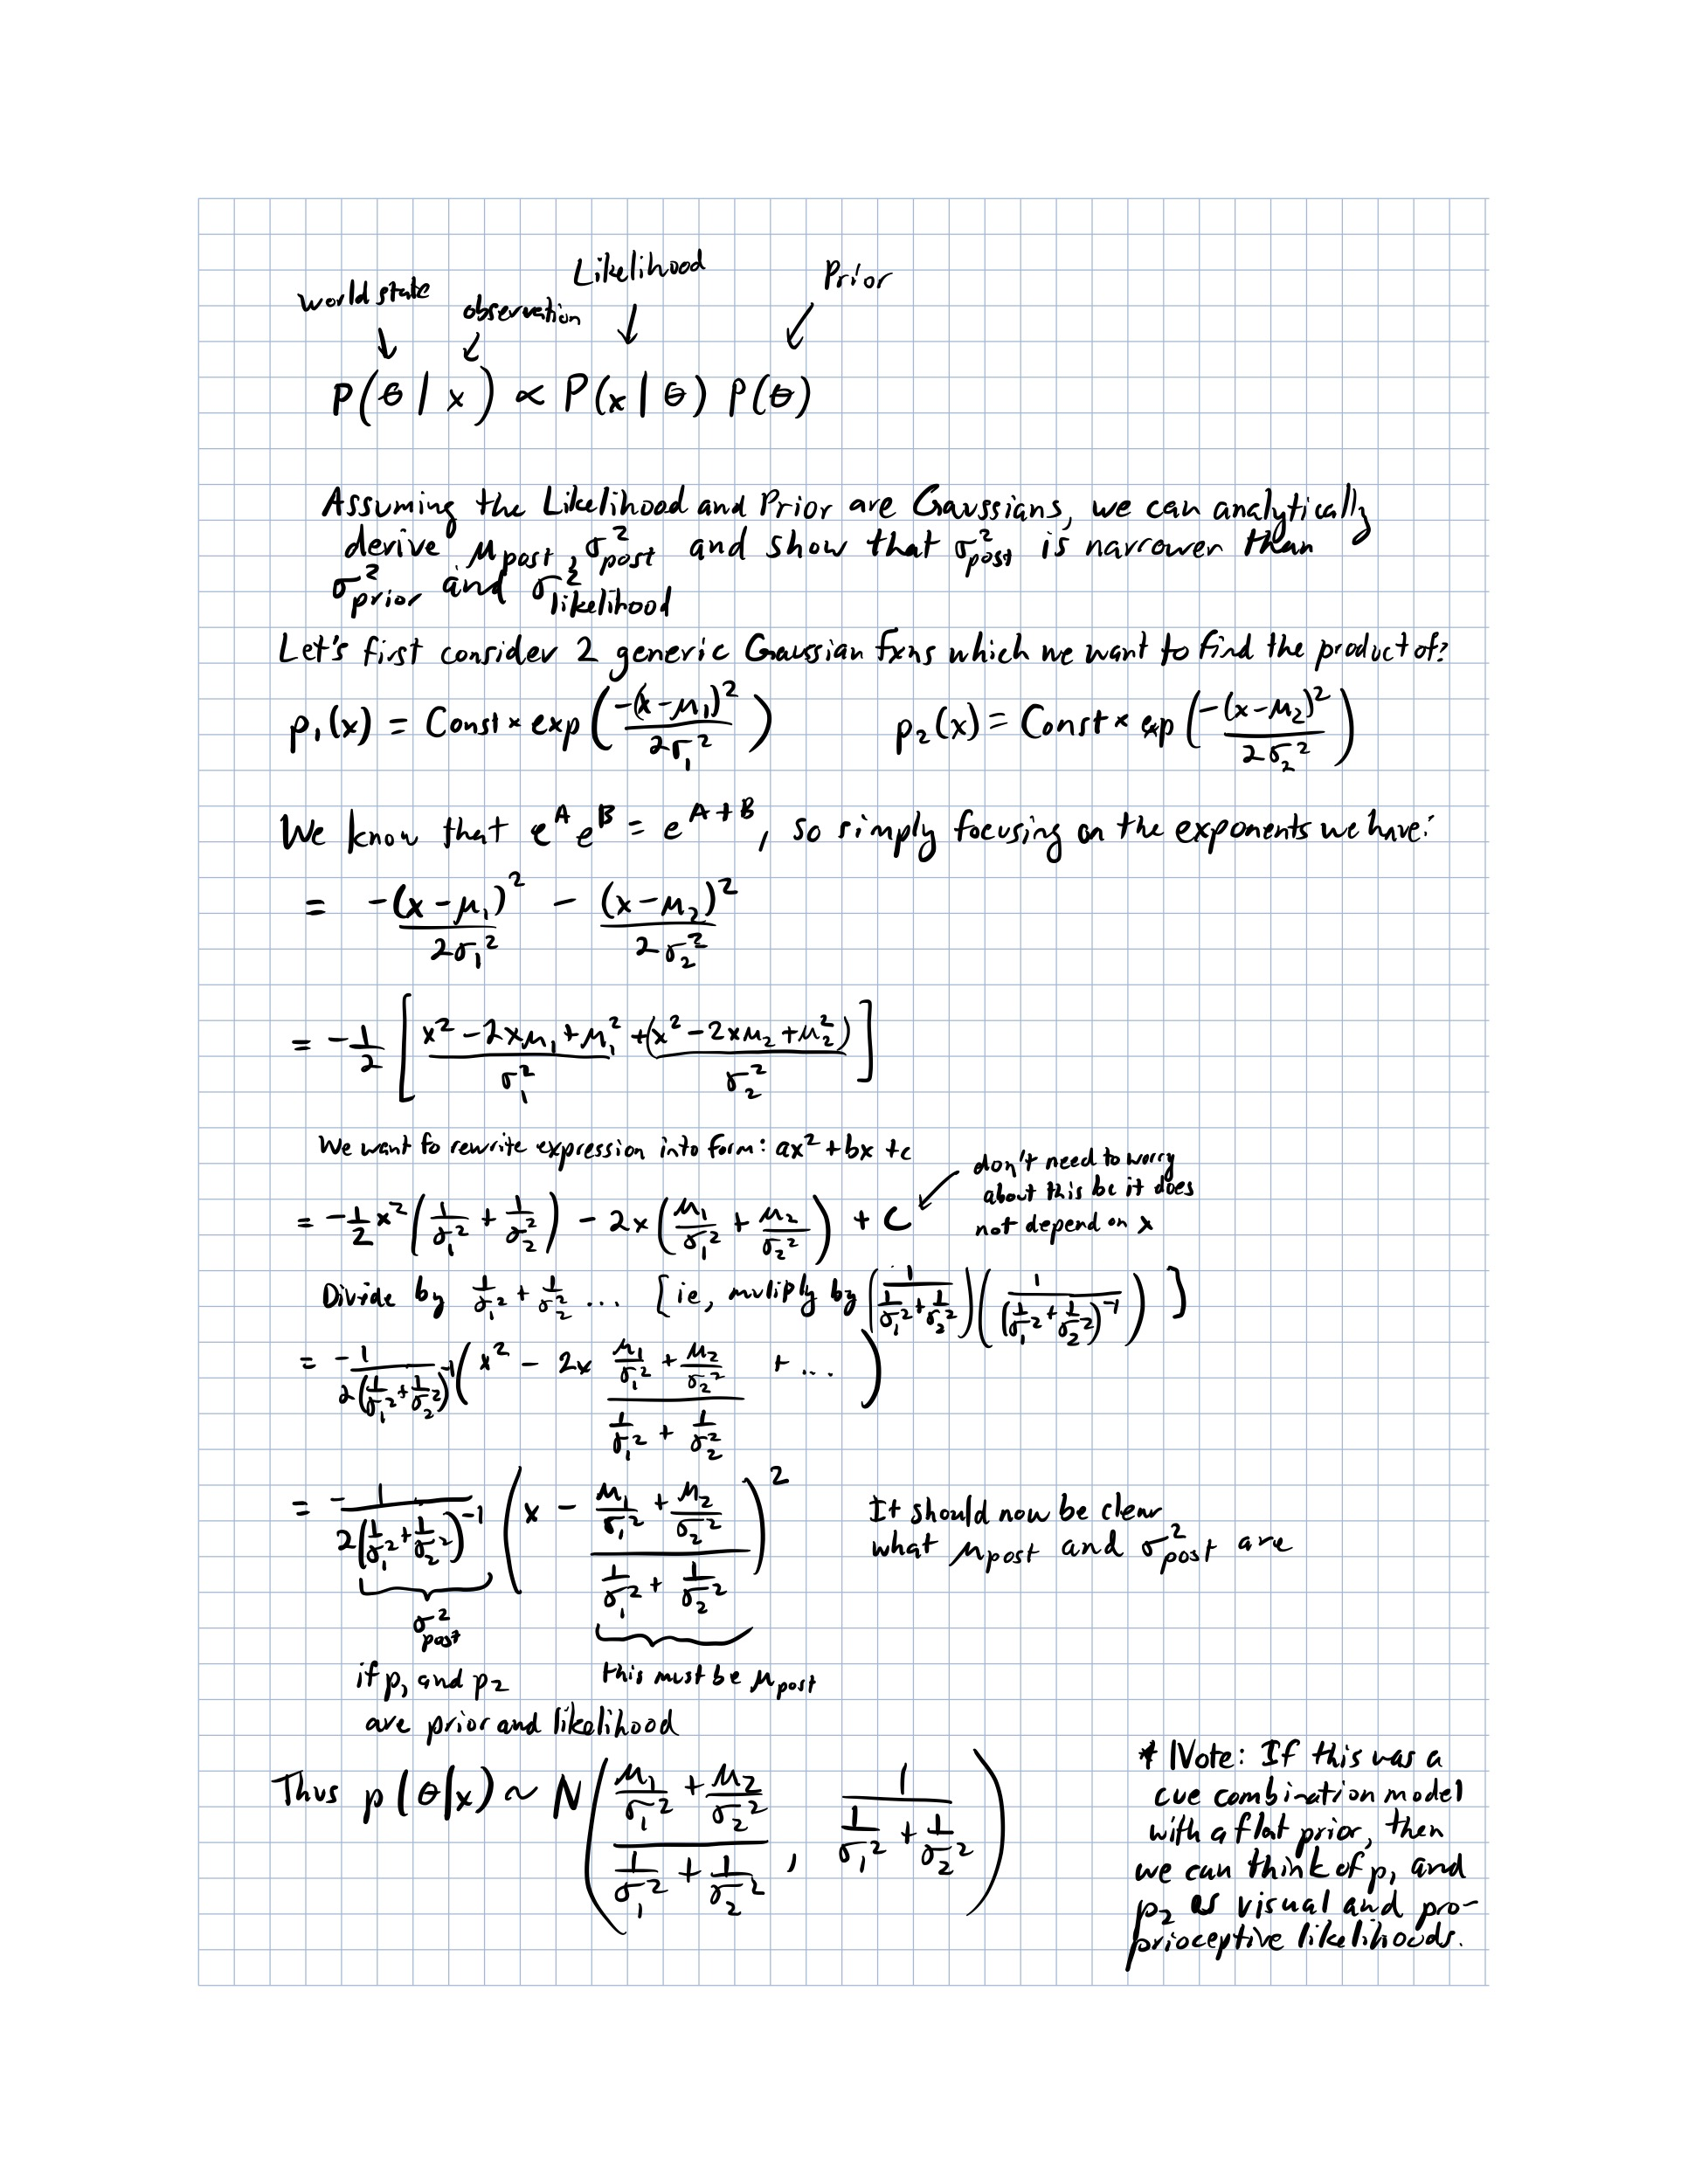
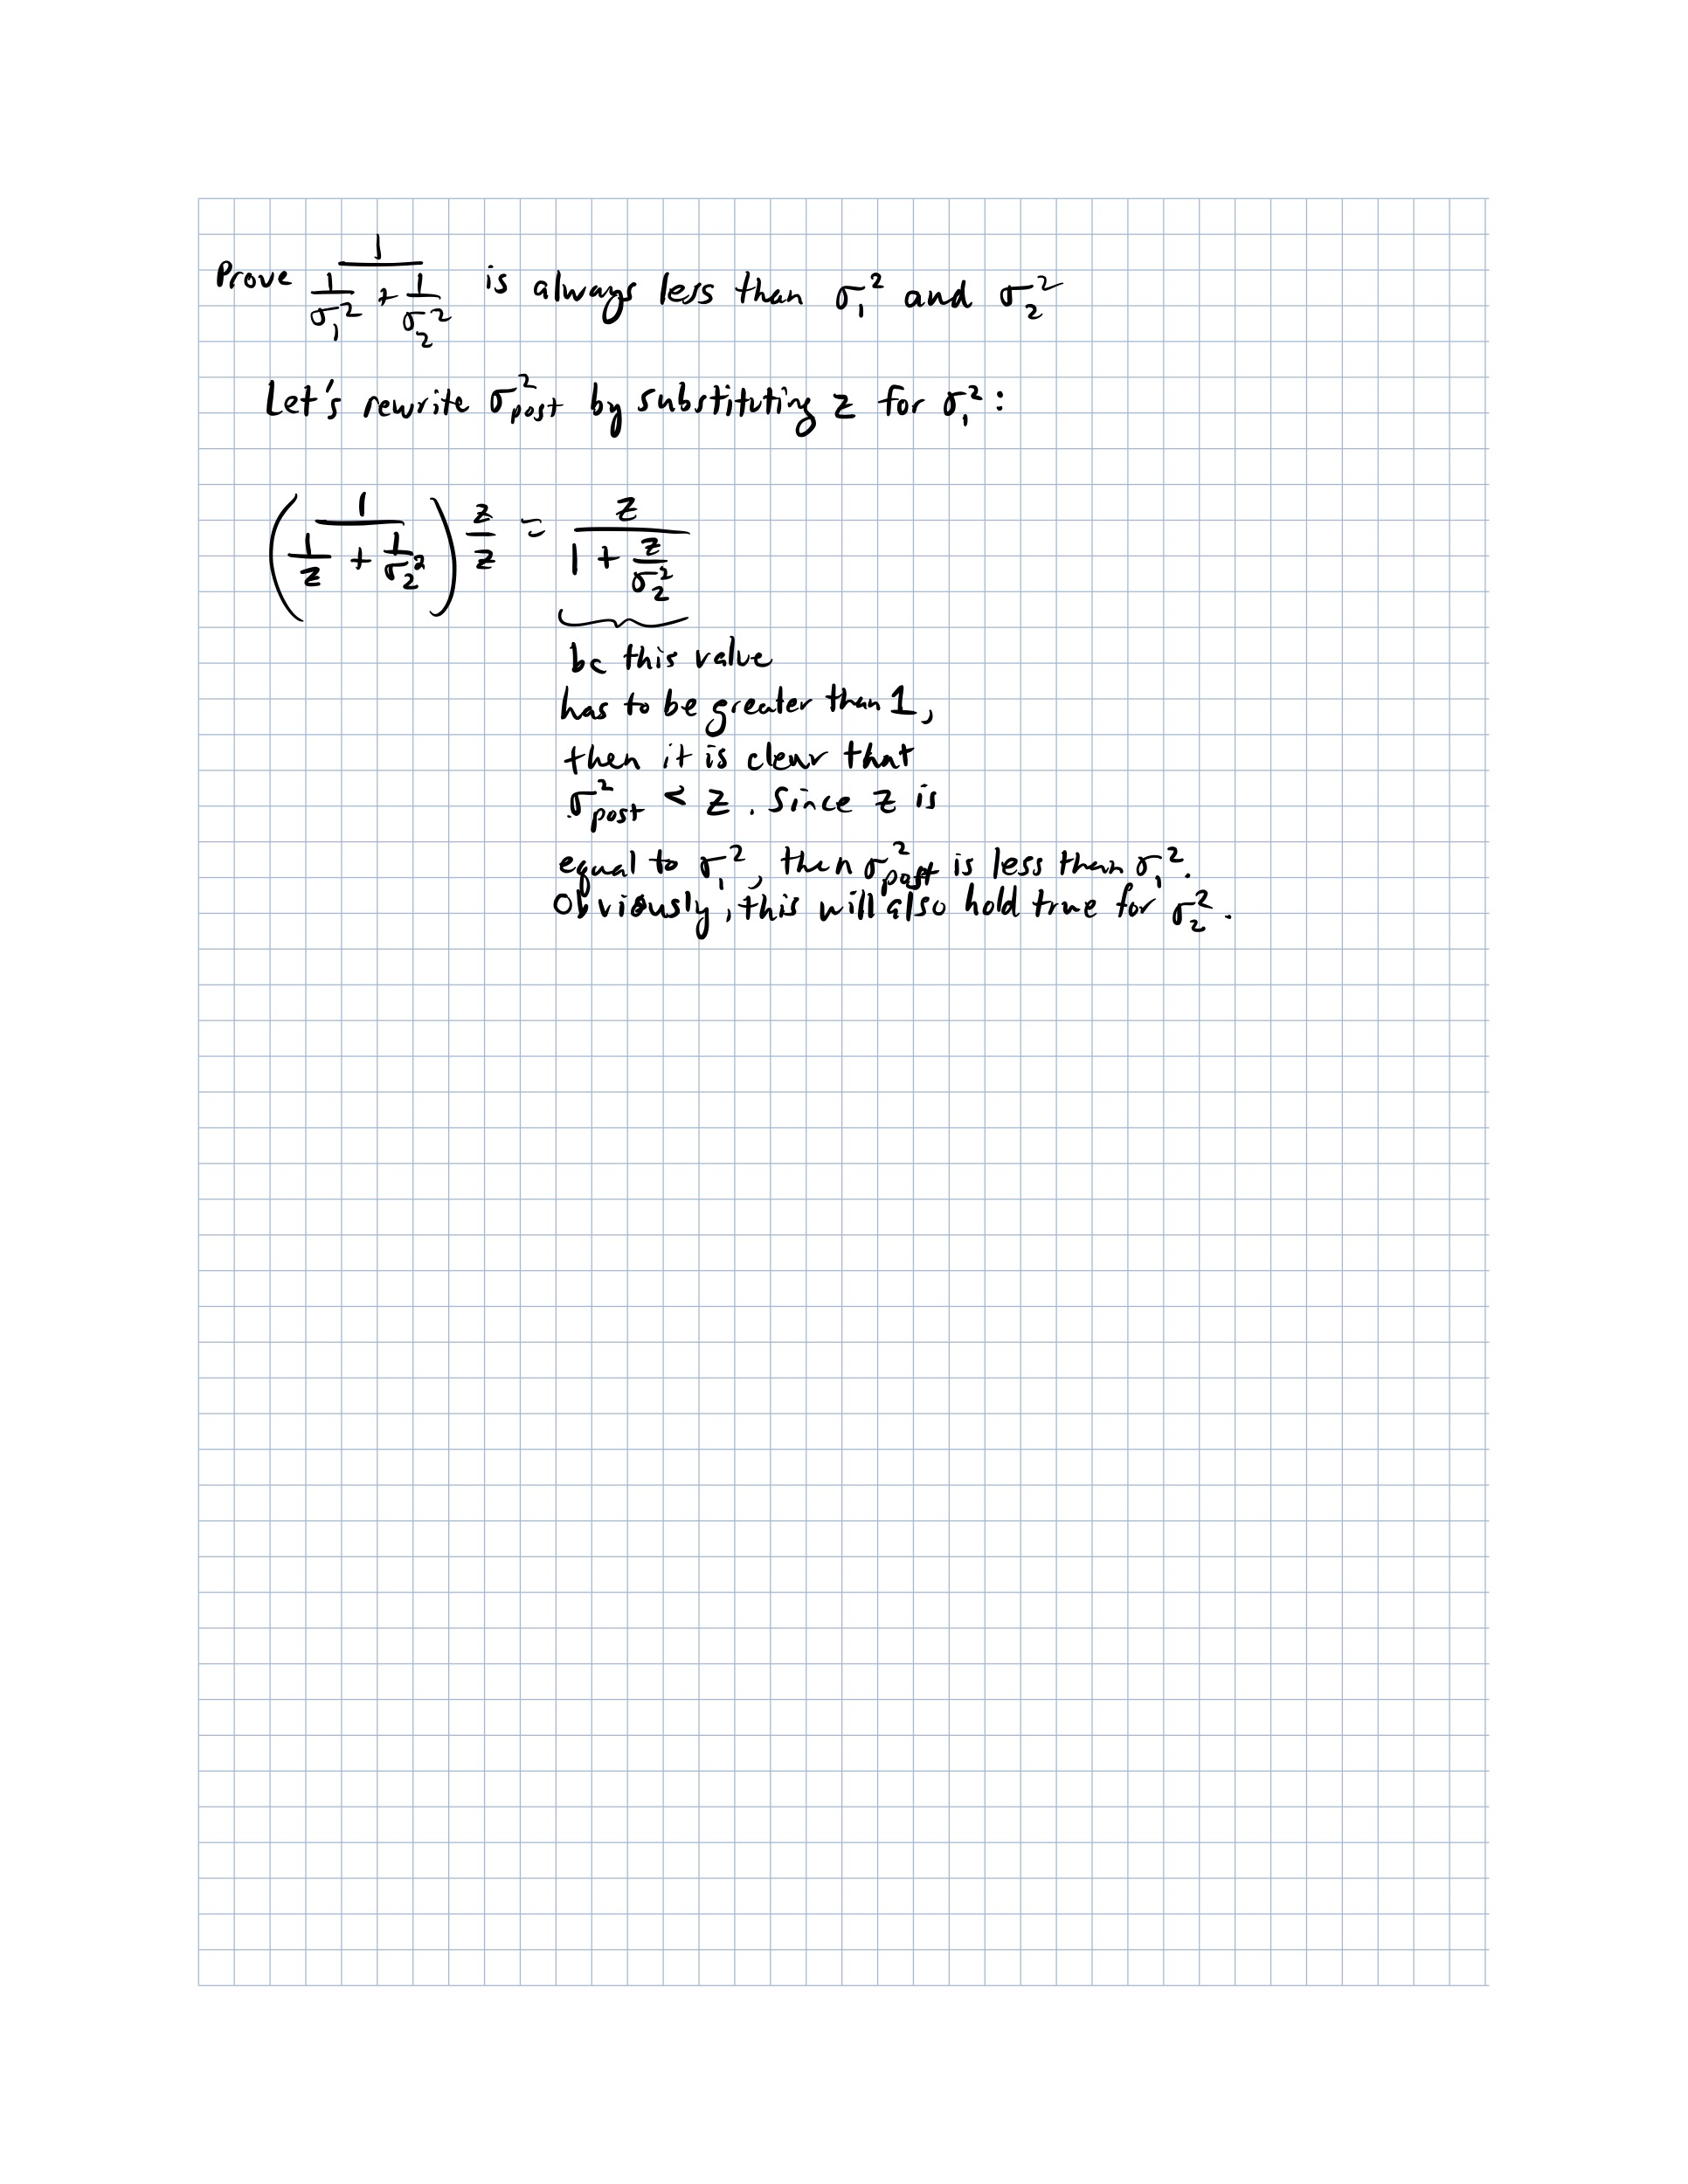